<a href="https://colab.research.google.com/github/ZahraMousakhani/CS-SBU-NeuralNetwork_MSc2021-projects/blob/main/ZahraMousakhani-99422187/project4/assignment_4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install kaggle

In [ ]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"zahramousakhani","key":"755da9f324f8575f4914cdb3228a0941"}'}

In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle competitions download -c nlp-getting-started


  0% 0.00/411k [00:00<?, ?B/s]
100% 411k/411k [00:00<00:00, 61.6MB/s]
  0% 0.00/22.2k [00:00<?, ?B/s]
100% 22.2k/22.2k [00:00<00:00, 43.2MB/s]
  0% 0.00/965k [00:00<?, ?B/s]
100% 965k/965k [00:00<00:00, 64.0MB/s]


In [ ]:
!ls

drive  kaggle.json  sample_data  sample_submission.csv	test.csv  train.csv


In [ ]:
!pip install torchtext

In [ ]:
import os
import sys
import warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")
    
import numpy as np
import pandas as pd
import sklearn

# Libraries and packages for text (pre-)processing 
import string
import re
import nltk
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import time
from torchtext.legacy import data
import torch
from torchtext import data
import torch.nn as nn

print("Python version:", sys.version)
print("Version info.:", sys.version_info)
print("pandas version:", pd.__version__)
print("numpy version:", np.__version__)
print("skearn version:", sklearn.__version__)
print("re version:", re.__version__)
print("nltk version:", nltk.__version__)

for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

Python version: 3.7.10 (default, May  3 2021, 02:48:31) 
[GCC 7.5.0]
Version info.: sys.version_info(major=3, minor=7, micro=10, releaselevel='final', serial=0)
pandas version: 1.1.5
numpy version: 1.19.5
skearn version: 0.22.2.post1
re version: 2.2.1
nltk version: 3.2.5


In [ ]:
#read the data:
train_df = pd.read_csv("/content/train.csv")
display(train_df.shape, train_df.head())

(7613, 5)

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [ ]:
#some early exploration:
display(train_df[~train_df["location"].isnull()].head())
display(train_df[train_df["target"] == 0]["text"].values[1])
display(train_df[train_df["target"] == 1]["text"].values[1])

,id,keyword,location,text,target
31,48,ablaze,Birmingham,@bbcmtd Wholesale Markets ablaze http://t.co/l...,1
32,49,ablaze,Est. September 2012 - Bristol,We always try to bring the heavy. #metal #RT h...,0
33,50,ablaze,AFRICA,#AFRICANBAZE: Breaking news:Nigeria flag set a...,1
34,52,ablaze,"Philadelphia, PA",Crying out for more! Set me ablaze,0
35,53,ablaze,"London, UK",On plus side LOOK AT THE SKY LAST NIGHT IT WAS...,0


'I love fruits'

'Forest fire near La Ronge Sask. Canada'

In [ ]:
train_df["text_clean"] = train_df["text"].apply(lambda x: x.lower())
display(train_df.head())

,id,keyword,location,text,target,text_clean
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1,our deeds are the reason of this #earthquake m...
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1,forest fire near la ronge sask. canada
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1,all residents asked to 'shelter in place' are ...
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1,"13,000 people receive #wildfires evacuation or..."
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1,just got sent this photo from ruby #alaska as ...


In [ ]:
!pip install contractions

     |████████████████████████████████| 327kB 2.9MB/s 
     |████████████████████████████████| 286kB 19.2MB/s 
  Created wheel for pyahocorasick: filename=pyahocorasick-1.4.2-cp37-cp37m-linux_x86_64.whl size=85401 sha256=e62b126533aa73e7fadf903f03fdbcf0961d23681c4d556583f2ab142006bb5b
  Stored in directory: /root/.cache/pip/wheels/3a/03/34/77e3ece0bba8b86bfac88a79f923b36d805cad63caeba38842
Successfully built pyahocorasick


In [ ]:
import contractions

# Test
test_text = """
            Y'all can't expand contractions I'd think. I'd like to know how I'd done that! 
            We're going to the zoo and I don't think I'll be home for dinner.
            Theyre going to the zoo and she'll be home for dinner.
            We should've do it in here but we shouldn't've eat it
            """
print("Test: ", contractions.fix(test_text))

train_df["text_clean"] = train_df["text_clean"].apply(lambda x: contractions.fix(x))

# double check
print(train_df["text"][67])
print(train_df["text_clean"][67])
print(train_df["text"][12])
print(train_df["text_clean"][12])

Test:  
            you all cannot expand contractions I would think. I would like to know how I would done that! 
            we are going to the zoo and I do not think I will be home for dinner.
            they are going to the zoo and she will be home for dinner.
            We should have do it in here but we should not have eat it
            
'I can't have kids cuz I got in a bicycle accident &amp; split my testicles. it's impossible for me to have kids' MICHAEL YOU ARE THE FATHER
'i cannot have kids cuz i got in a bicycle accident &amp; split my testicles. it is impossible for me to have kids' michael you are the father
#raining #flooding #Florida #TampaBay #Tampa 18 or 19 days. I've lost count 
#raining #flooding #florida #tampabay #tampa 18 or 19 days. I have lost count 


In [ ]:
def remove_URL(text):
    """
        Remove URLs from a sample string
    """
    return re.sub(r"https?://\S+|www\.\S+", "", text)

In [ ]:
# remove urls from the text
train_df["text_clean"] = train_df["text_clean"].apply(lambda x: remove_URL(x))

# double check
print(train_df["text"][31])
print(train_df["text_clean"][31])
print(train_df["text"][37])
print(train_df["text_clean"][37])
print(train_df["text"][62])
print(train_df["text_clean"][62])

@bbcmtd Wholesale Markets ablaze http://t.co/lHYXEOHY6C
@bbcmtd wholesale markets ablaze 
INEC Office in Abia Set Ablaze - http://t.co/3ImaomknnA
inec office in abia set ablaze - 
Rene Ablaze &amp; Jacinta - Secret 2k13 (Fallen Skies Edit) - Mar 30 2013  https://t.co/7MLMsUzV1Z
rene ablaze &amp; jacinta - secret 2k13 (fallen skies edit) - mar 30 2013  


In [ ]:
def remove_html(text):
    """
        Remove the html in sample text
    """
    html = re.compile(r"<.*?>|&([a-z0-9]+|#[0-9]{1,6}|#x[0-9a-f]{1,6});")
    return re.sub(html, "", text)

In [ ]:
# remove html from the text
train_df["text_clean"] = train_df["text_clean"].apply(lambda x: remove_html(x))

# double check
print(train_df["text"][62])
print(train_df["text_clean"][62])
print(train_df["text"][7385])
print(train_df["text_clean"][7385])

Rene Ablaze &amp; Jacinta - Secret 2k13 (Fallen Skies Edit) - Mar 30 2013  https://t.co/7MLMsUzV1Z
rene ablaze  jacinta - secret 2k13 (fallen skies edit) - mar 30 2013  
NW Michigan #WindStorm (Sheer) Recovery Updates: Leelanau &amp; Grand Traverse - State of Emergency 2b extended http://t.co/OSKfyj8CK7 #BeSafe
nw michigan #windstorm (sheer) recovery updates: leelanau  grand traverse - state of emergency 2b extended  #besafe


In [ ]:
def remove_non_ascii(text):
    """
        Remove non-ASCII characters 
    """
    return re.sub(r'[^\x00-\x7f]',r'', text) # or ''.join([x for x in text if x in string.printable])

In [ ]:
# remove non-ascii characters from the text
train_df["text_clean"] = train_df["text_clean"].apply(lambda x: remove_non_ascii(x))

# double check
print(train_df["text"][38])
print(train_df["text_clean"][38])
print(train_df["text"][7586])
print(train_df["text_clean"][7586])

Barbados #Bridgetown JAMAICA ÛÒ Two cars set ablaze: SANTA CRUZ ÛÓ Head of the St Elizabeth Police Superintende...  http://t.co/wDUEaj8Q4J
barbados #bridgetown jamaica  two cars set ablaze: santa cruz  head of the st elizabeth police superintende...  
#Sismo DETECTADO #JapÌ_n 15:41:07 Seismic intensity 0 Iwate Miyagi JST #?? http://t.co/gMoUl9zQ2Q
#sismo detectado #jap_n 15:41:07 seismic intensity 0 iwate miyagi jst #?? 


In [ ]:
def remove_punct(text):
 
  #return re.sub(r'[]!"$%&\'()*+,./:;=#@?[\\^_`{|}~-]+', "", text)
  return text.translate(str.maketrans('', '', string.punctuation))

In [ ]:
# remove punctuations from the text
train_df["text_clean"] = train_df["text_clean"].apply(lambda x: remove_punct(x))

# double check
print(train_df["text"][5])
print(train_df["text_clean"][5])
print(train_df["text"][7597])
print(train_df["text_clean"][7597])

#RockyFire Update => California Hwy. 20 closed in both directions due to Lake County fire - #CAfire #wildfires
rockyfire update  california hwy 20 closed in both directions due to lake county fire  cafire wildfires
#??? #?? #??? #??? MH370: Aircraft debris found on La Reunion is from missing Malaysia Airlines ... http://t.co/5B7qT2YxdA
    mh370 aircraft debris found on la reunion is from missing malaysia airlines  


In [ ]:
def other_clean(text):
        """
            Other manual text cleaning techniques
        """
        # Typos, slang and other
        sample_typos_slang = {
                                "w/e": "whatever",
                                "usagov": "usa government",
                                "recentlu": "recently",
                                "ph0tos": "photos",
                                "amirite": "am i right",
                                "exp0sed": "exposed",
                                "<3": "love",
                                "luv": "love",
                                "amageddon": "armageddon",
                                "trfc": "traffic",
                                "16yr": "16 year"
                                }
        # Acronyms
        sample_acronyms =  { 
                            "mh370": "malaysia airlines flight 370",
                            "okwx": "oklahoma city weather",
                            "arwx": "arkansas weather",    
                            "gawx": "georgia weather",  
                            "scwx": "south carolina weather",  
                            "cawx": "california weather",
                            "tnwx": "tennessee weather",
                            "azwx": "arizona weather",  
                            "alwx": "alabama weather",
                            "usnwsgov": "united states national weather service",
                            "2mw": "tomorrow"
                            }
        # Some common abbreviations 
        sample_abbr = {
                        "$" : " dollar ",
                        "€" : " euro ",
                        "4ao" : "for adults only",
                        "a.m" : "before midday",
                        "a3" : "anytime anywhere anyplace",
                        "aamof" : "as a matter of fact",
                        "acct" : "account",
                        "adih" : "another day in hell",
                        "afaic" : "as far as i am concerned",
                        "afaict" : "as far as i can tell",
                        "afaik" : "as far as i know",
                        "afair" : "as far as i remember",
                        "afk" : "away from keyboard",
                        "app" : "application",
                        "approx" : "approximately",
                        "apps" : "applications",
                        "asap" : "as soon as possible",
                        "asl" : "age, sex, location",
                        "atk" : "at the keyboard",
                        "ave." : "avenue",
                        "aymm" : "are you my mother",
                        "ayor" : "at your own risk", 
                        "b&b" : "bed and breakfast",
                        "b+b" : "bed and breakfast",
                        "b.c" : "before christ",
                        "b2b" : "business to business",
                        "b2c" : "business to customer",
                        "b4" : "before",
                        "b4n" : "bye for now",
                        "b@u" : "back at you",
                        "bae" : "before anyone else",
                        "bak" : "back at keyboard",
                        "bbbg" : "bye bye be good",
                        "bbc" : "british broadcasting corporation",
                        "bbias" : "be back in a second",
                        "bbl" : "be back later",
                        "bbs" : "be back soon",
                        "be4" : "before",
                        "bfn" : "bye for now",
                        "blvd" : "boulevard",
                        "bout" : "about",
                        "brb" : "be right back",
                        "bros" : "brothers",
                        "brt" : "be right there",
                        "bsaaw" : "big smile and a wink",
                        "btw" : "by the way",
                        "bwl" : "bursting with laughter",                             
                        "c/o" : "care of",
                        "cet" : "central european time",
                        "cf" : "compare",
                        "cia" : "central intelligence agency",
                        "csl" : "can not stop laughing",
                        "cu" : "see you",
                        "cul8r" : "see you later",
                        "cv" : "curriculum vitae",
                        "cwot" : "complete waste of time",
                        "cya" : "see you",
                        "cyt" : "see you tomorrow",
                        "dae" : "does anyone else",
                        "dbmib" : "do not bother me i am busy",
                        "diy" : "do it yourself",
                        "dm" : "direct message",
                        "dwh" : "during work hours",
                        "e123" : "easy as one two three",
                        "eet" : "eastern european time",
                        "eg" : "example",
                        "embm" : "early morning business meeting",
                        "encl" : "enclosed",
                        "encl." : "enclosed",
                        "etc" : "and so on",
                        "faq" : "frequently asked questions",
                        "fawc" : "for anyone who cares",
                        "fb" : "facebook",
                        "fc" : "fingers crossed",
                        "fig" : "figure",
                        "fimh" : "forever in my heart", 
                        "ft." : "feet",
                        "ft" : "featuring",
                        "ftl" : "for the loss",
                        "ftw" : "for the win",
                        "fwiw" : "for what it is worth",
                        "fyi" : "for your information",
                        "g9" : "genius",
                        "gahoy" : "get a hold of yourself",
                        "gal" : "get a life",
                        "gcse" : "general certificate of secondary education",
                        "gfn" : "gone for now",
                        "gg" : "good game",
                        "gl" : "good luck",
                        "glhf" : "good luck have fun",
                        "gmt" : "greenwich mean time",
                        "gmta" : "great minds think alike",
                        "gn" : "good night",
                        "g.o.a.t" : "greatest of all time",
                        "goat" : "greatest of all time",
                        "goi" : "get over it",
                        "gps" : "global positioning system",
                        "gr8" : "great",
                        "gratz" : "congratulations",
                        "gyal" : "girl",
                        "h&c" : "hot and cold",   
                        "hp" : "horsepower",
                        "hr" : "hour",
                        "hrh" : "his royal highness",
                        "ht" : "height",
                        "ibrb" : "i will be right back",
                        "ic" : "i see",
                        "icq" : "i seek you",
                        "icymi" : "in case you missed it",
                        "idc" : "i do not care",
                        "idgadf" : "i do not give a damn fuck",
                        "idgaf" : "i do not give a fuck",
                        "idk" : "i do not know",
                        "ie" : "that is",
                        "i.e" : "that is",
                        "ifyp" : "i feel your pain",
                        "IG" : "instagram",
                        "iirc" : "if i remember correctly",
                        "ilu" : "i love you",
                        "ily" : "i love you",
                        "imho" : "in my humble opinion",
                        "imo" : "in my opinion",
                        "imu" : "i miss you",
                        "iow" : "in other words",
                        "irl" : "in real life",
                        "j4f" : "just for fun",
                        "jic" : "just in case", 
                        "jk" : "just kidding",
                        "jsyk" : "just so you know",
                        "l8r" : "later",
                        "lb" : "pound",
                        "lbs" : "pounds",
                        "ldr" : "long distance relationship",
                        "lmao" : "laugh my ass off",
                        "lmfao" : "laugh my fucking ass off",
                        "lol" : "laughing out loud",
                        "ltd" : "limited",
                        "ltns" : "long time no see",
                        "m8" : "mate",
                        "mf" : "motherfucker",
                        "mfs" : "motherfuckers",
                        "mfw" : "my face when",
                        "mofo" : "motherfucker",
                        "mph" : "miles per hour",
                        "mr" : "mister",
                        "mrw" : "my reaction when",
                        "ms" : "miss",
                        "mte" : "my thoughts exactly",
                        "nagi" : "not a good idea",
                        "nbc" : "national broadcasting company",
                        "nbd" : "not big deal",
                        "nfs" : "not for sale",
                        "ngl" : "not going to lie",   
                        "nhs" : "national health service",
                        "nrn" : "no reply necessary",
                        "nsfl" : "not safe for life",
                        "nsfw" : "not safe for work",
                        "nth" : "nice to have",
                        "nvr" : "never",
                        "nyc" : "new york city",
                        "oc" : "original content",
                        "og" : "original",
                        "ohp" : "overhead projector",
                        "oic" : "oh i see",
                        "omdb" : "over my dead body",
                        "omg" : "oh my god",
                        "omw" : "on my way",
                        "p.a" : "per annum",
                        "p.m" : "after midday",
                        "pm" : "prime minister",
                        "poc" : "people of color",
                        "pov" : "point of view",
                        "pp" : "pages",
                        "ppl" : "people",
                        "prw" : "parents are watching",
                        "ps" : "postscript",
                        "pt" : "point", 
                        "ptb" : "please text back",
                        "pto" : "please turn over",
                        "qpsa" : "what happens", #"que pasa",
                        "ratchet" : "rude",
                        "rbtl" : "read between the lines",
                        "rlrt" : "real life retweet", 
                        "rofl" : "rolling on the floor laughing",
                        "roflol" : "rolling on the floor laughing out loud",
                        "rotflmao" : "rolling on the floor laughing my ass off",
                        "rt" : "retweet",
                        "ruok" : "are you ok",
                        "sfw" : "safe for work",
                        "sk8" : "skate",
                        "smh" : "shake my head",
                        "sq" : "square",
                        "srsly" : "seriously", 
                        "ssdd" : "same stuff different day",
                        "tbh" : "to be honest",
                        "tbs" : "tablespooful",
                        "tbsp" : "tablespooful",
                        "tfw" : "that feeling when",
                        "thks" : "thank you",
                        "tho" : "though",
                        "thx" : "thank you",
                        "tia" : "thanks in advance",
                        "til" : "today i learned",
                        "tl;dr" : "too long i did not read",
                        "tldr" : "too long i did not read",
                        "tmb" : "tweet me back",
                        "tntl" : "trying not to laugh",
                        "ttyl" : "talk to you later",
                        "u" : "you",
                        "u2" : "you too",
                        "u4e" : "yours for ever",
                        "utc" : "coordinated universal time",
                        "w/" : "with",
                        "w/o" : "without",
                        "w8" : "wait",
                        "wassup" : "what is up",
                        "wb" : "welcome back",
                        "wtf" : "what the fuck",
                        "wtg" : "way to go",
                        "wtpa" : "where the party at",
                        "wuf" : "where are you from",
                        "wuzup" : "what is up",
                        "wywh" : "wish you were here",
                        "yd" : "yard",
                        "ygtr" : "you got that right",
                        "ynk" : "you never know",
                        "zzz" : "sleeping bored and tired"
                        }  
        sample_typos_slang_pattern = re.compile(r'(?<!\w)(' + '|'.join(re.escape(key) for key in sample_typos_slang.keys()) + r')(?!\w)')
        sample_acronyms_pattern = re.compile(r'(?<!\w)(' + '|'.join(re.escape(key) for key in sample_acronyms.keys()) + r')(?!\w)')
        sample_abbr_pattern = re.compile(r'(?<!\w)(' + '|'.join(re.escape(key) for key in sample_abbr.keys()) + r')(?!\w)')
        
        text = sample_typos_slang_pattern.sub(lambda x: sample_typos_slang[x.group()], text)
        text = sample_acronyms_pattern.sub(lambda x: sample_acronyms[x.group()], text)
        text = sample_abbr_pattern.sub(lambda x: sample_abbr[x.group()], text)
        
        return text                                               

In [ ]:
# Test
test_text = """
            brb with some sample ph0tos I lov u. I need some $ for 2mw.
            """
print("Test: ", other_clean(test_text))

# remove punctuations from the text
train_df["text_clean"] = train_df["text_clean"].apply(lambda x: other_clean(x))

# double check
print(train_df["text"][1844])
print(train_df["text_clean"][1844])
print(train_df["text"][4409])
print(train_df["text_clean"][4409])

Test:  
            be right back with some sample photos I lov you. I need some  dollar  for tomorrow.
            
MH370: Intact part lifts odds plane glided not crashed into sea http://t.co/8pdnHH6tzH
malaysia airlines flight 370 intact part lifts odds plane glided not crashed into sea 
@USAgov Koreans are performing hijacking of the Tokyo Olympic Games.https://t.co/APkSnpLXZj
usa government koreans are performing hijacking of the tokyo olympic games


In [ ]:
# Tokenizing the tweet base texts.
import nltk
nltk.download('punkt')
from nltk.tokenize import word_tokenize

train_df["tokenized"] = train_df["text_clean"].apply(word_tokenize)
train_df.head()

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


,id,keyword,location,text,target,text_clean,tokenized
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1,our deeds are the reason of this earthquake ma...,"[our, deeds, are, the, reason, of, this, earth..."
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1,forest fire near la ronge sask canada,"[forest, fire, near, la, ronge, sask, canada]"
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1,all residents asked to shelter in place are be...,"[all, residents, asked, to, shelter, in, place..."
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1,13000 people receive wildfires evacuation orde...,"[13000, people, receive, wildfires, evacuation..."
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1,just got sent this photo from ruby alaska as s...,"[just, got, sent, this, photo, from, ruby, ala..."


In [ ]:
# Removing stopwords.
nltk.download("stopwords")
from nltk.corpus import stopwords

stop = set(stopwords.words('english'))
train_df['stopwords_removed'] = train_df['tokenized'].apply(lambda x: [word for word in x if word not in stop])
train_df.head()

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


,id,keyword,location,text,target,text_clean,tokenized,stopwords_removed
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1,our deeds are the reason of this earthquake ma...,"[our, deeds, are, the, reason, of, this, earth...","[deeds, reason, earthquake, may, allah, forgiv..."
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1,forest fire near la ronge sask canada,"[forest, fire, near, la, ronge, sask, canada]","[forest, fire, near, la, ronge, sask, canada]"
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1,all residents asked to shelter in place are be...,"[all, residents, asked, to, shelter, in, place...","[residents, asked, shelter, place, notified, o..."
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1,13000 people receive wildfires evacuation orde...,"[13000, people, receive, wildfires, evacuation...","[13000, people, receive, wildfires, evacuation..."
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1,just got sent this photo from ruby alaska as s...,"[just, got, sent, this, photo, from, ruby, ala...","[got, sent, photo, ruby, alaska, smoke, wildfi..."


In [ ]:
#stemming: 
from nltk.stem import SnowballStemmer

def snowball_stemmer(text):
    """
        Stem words in list of tokenized words with SnowballStemmer
    """
    stemmer = nltk.SnowballStemmer("english")
    stems = [stemmer.stem(i) for i in text]
    return stems

In [ ]:
train_df['snowball_stemmer'] = train_df['stopwords_removed'].apply(lambda x: snowball_stemmer(x))
train_df.head()

,id,keyword,location,text,target,text_clean,tokenized,stopwords_removed,snowball_stemmer
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1,our deeds are the reason of this earthquake ma...,"[our, deeds, are, the, reason, of, this, earth...","[deeds, reason, earthquake, may, allah, forgiv...","[deed, reason, earthquak, may, allah, forgiv, us]"
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1,forest fire near la ronge sask canada,"[forest, fire, near, la, ronge, sask, canada]","[forest, fire, near, la, ronge, sask, canada]","[forest, fire, near, la, rong, sask, canada]"
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1,all residents asked to shelter in place are be...,"[all, residents, asked, to, shelter, in, place...","[residents, asked, shelter, place, notified, o...","[resid, ask, shelter, place, notifi, offic, ev..."
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1,13000 people receive wildfires evacuation orde...,"[13000, people, receive, wildfires, evacuation...","[13000, people, receive, wildfires, evacuation...","[13000, peopl, receiv, wildfir, evacu, order, ..."
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1,just got sent this photo from ruby alaska as s...,"[just, got, sent, this, photo, from, ruby, ala...","[got, sent, photo, ruby, alaska, smoke, wildfi...","[got, sent, photo, rubi, alaska, smoke, wildfi..."


In [ ]:
from nltk.corpus import wordnet
from nltk.corpus import brown
nltk.download('wordnet')
nltk.download('brown')
wordnet_map = {"N":wordnet.NOUN, 
               "V":wordnet.VERB, 
               "J":wordnet.ADJ, 
               "R":wordnet.ADV
              }
    
train_sents = brown.tagged_sents(categories='news')
t0 = nltk.DefaultTagger('NN')
t1 = nltk.UnigramTagger(train_sents, backoff=t0)
t2 = nltk.BigramTagger(train_sents, backoff=t1)

def pos_tag_wordnet(text, pos_tag_type="pos_tag"):
    """
        Create pos_tag with wordnet format
    """
    pos_tagged_text = t2.tag(text)
    
    # map the pos tagging output with wordnet output 
    pos_tagged_text = [(word, wordnet_map.get(pos_tag[0])) if pos_tag[0] in wordnet_map.keys() else (word, wordnet.NOUN) for (word, pos_tag) in pos_tagged_text ]
    return pos_tagged_text

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package brown to /root/nltk_data...
[nltk_data]   Package brown is already up-to-date!


In [ ]:
train_df['combined_postag_wnet'] = train_df['stopwords_removed'].apply(lambda x: pos_tag_wordnet(x))

train_df.head()

,id,keyword,location,text,target,text_clean,tokenized,stopwords_removed,snowball_stemmer,combined_postag_wnet
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1,our deeds are the reason of this earthquake ma...,"[our, deeds, are, the, reason, of, this, earth...","[deeds, reason, earthquake, may, allah, forgiv...","[deed, reason, earthquak, may, allah, forgiv, us]","[(deeds, n), (reason, n), (earthquake, n), (ma..."
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1,forest fire near la ronge sask canada,"[forest, fire, near, la, ronge, sask, canada]","[forest, fire, near, la, ronge, sask, canada]","[forest, fire, near, la, rong, sask, canada]","[(forest, n), (fire, n), (near, n), (la, n), (..."
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1,all residents asked to shelter in place are be...,"[all, residents, asked, to, shelter, in, place...","[residents, asked, shelter, place, notified, o...","[resid, ask, shelter, place, notifi, offic, ev...","[(residents, n), (asked, v), (shelter, n), (pl..."
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1,13000 people receive wildfires evacuation orde...,"[13000, people, receive, wildfires, evacuation...","[13000, people, receive, wildfires, evacuation...","[13000, peopl, receiv, wildfir, evacu, order, ...","[(13000, n), (people, n), (receive, v), (wildf..."
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1,just got sent this photo from ruby alaska as s...,"[just, got, sent, this, photo, from, ruby, ala...","[got, sent, photo, ruby, alaska, smoke, wildfi...","[got, sent, photo, rubi, alaska, smoke, wildfi...","[(got, v), (sent, v), (photo, n), (ruby, n), (..."


In [ ]:
from nltk.stem import WordNetLemmatizer

def lemmatize_word(text):
    """
        Lemmatize the tokenized words
    """

    lemmatizer = WordNetLemmatizer()
    lemma = [lemmatizer.lemmatize(word, tag) for word, tag in text]
    return lemma

In [ ]:
%time 

# Test with POS Tagging
lemmatizer = WordNetLemmatizer()

train_df["lemmatize_word_w_pos"] = train_df["combined_postag_wnet"].apply(lambda x: lemmatize_word(x))
train_df['lemmatize_word_w_pos'] = train_df['lemmatize_word_w_pos'].apply(lambda x: [word for word in x if word not in stop]) # double check to remove stop words
train_df['lemmatize_text'] = [' '.join(map(str, l)) for l in train_df['lemmatize_word_w_pos']] # join back to text

train_df.head()

CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 5.48 µs


,id,keyword,location,text,target,text_clean,tokenized,stopwords_removed,snowball_stemmer,combined_postag_wnet,lemmatize_word_w_pos,lemmatize_text
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1,our deeds are the reason of this earthquake ma...,"[our, deeds, are, the, reason, of, this, earth...","[deeds, reason, earthquake, may, allah, forgiv...","[deed, reason, earthquak, may, allah, forgiv, us]","[(deeds, n), (reason, n), (earthquake, n), (ma...","[deed, reason, earthquake, may, allah, forgive...",deed reason earthquake may allah forgive u
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1,forest fire near la ronge sask canada,"[forest, fire, near, la, ronge, sask, canada]","[forest, fire, near, la, ronge, sask, canada]","[forest, fire, near, la, rong, sask, canada]","[(forest, n), (fire, n), (near, n), (la, n), (...","[forest, fire, near, la, ronge, sask, canada]",forest fire near la ronge sask canada
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1,all residents asked to shelter in place are be...,"[all, residents, asked, to, shelter, in, place...","[residents, asked, shelter, place, notified, o...","[resid, ask, shelter, place, notifi, offic, ev...","[(residents, n), (asked, v), (shelter, n), (pl...","[resident, ask, shelter, place, notified, offi...",resident ask shelter place notified officer ev...
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1,13000 people receive wildfires evacuation orde...,"[13000, people, receive, wildfires, evacuation...","[13000, people, receive, wildfires, evacuation...","[13000, peopl, receiv, wildfir, evacu, order, ...","[(13000, n), (people, n), (receive, v), (wildf...","[13000, people, receive, wildfire, evacuation,...",13000 people receive wildfire evacuation order...
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1,just got sent this photo from ruby alaska as s...,"[just, got, sent, this, photo, from, ruby, ala...","[got, sent, photo, ruby, alaska, smoke, wildfi...","[got, sent, photo, rubi, alaska, smoke, wildfi...","[(got, v), (sent, v), (photo, n), (ruby, n), (...","[get, send, photo, ruby, alaska, smoke, wildfi...",get send photo ruby alaska smoke wildfire pour...


In [ ]:
display(train_df["text"][0], train_df["lemmatize_text"][0])
display(train_df["text"][5], train_df["lemmatize_text"][5])
display(train_df["text"][10], train_df["lemmatize_text"][10])
display(train_df["text"][15], train_df["lemmatize_text"][15])
display(train_df["text"][20], train_df["lemmatize_text"][20])

'Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all'

'deed reason earthquake may allah forgive u'

'#RockyFire Update => California Hwy. 20 closed in both directions due to Lake County fire - #CAfire #wildfires'

'rockyfire update california hwy 20 close direction due lake county fire cafire wildfire'

'Three people died from the heat wave so far'

'three people die heat wave far'

"What's up man?"

'man'

'this is ridiculous....'

'ridiculous'

In [ ]:
def get_average_vec(tokens_list, vector, generate_missing=False, k=300):
    """
        Calculate average embedding value of sentence from each word vector
    """
    if len(tokens_list)<1:
        return np.zeros(k)
    
    if generate_missing:
        vectorized = [vector[word] if word in vector else np.random.rand(k) for word in tokens_list]
    else:
        vectorized = [vector[word] if word in vector else np.zeros(k) for word in tokens_list]
    
    length = len(vectorized)
    summed = np.sum(vectorized, axis=0)
    averaged = np.divide(summed, length)
    return averaged

def get_embeddings(vectors, text, generate_missing=False, k=300):
    """
        create the sentence embedding
    """
    embeddings = text.apply(lambda x: get_average_vec(x, vectors, generate_missing=generate_missing, k=k))
    return list(embeddings)

In [ ]:
import gensim
from gensim.models.fasttext import FastText

fasttext_path = "/content/drive/MyDrive/wiki-news-300d-1M.vec"
fasttext_model = gensim.models.KeyedVectors.load_word2vec_format(fasttext_path, binary=False, limit=200000)

In [ ]:
from keras.layers import Embedding
embeddings_fasttext = get_embeddings(fasttext_model, train_df["lemmatize_text"], k=300)

print("Embedding matrix size", len(embeddings_fasttext), len(embeddings_fasttext[0]))
print("The sentence: \"%s\" got embedding values: " % train_df["lemmatize_text"][0])
print(embeddings_fasttext[0])
print(type(embeddings_fasttext))

Embedding matrix size 7613 300
The sentence: "deed reason earthquake may allah forgive u" got embedding values: 
[-8.09166668e-02  2.61404759e-02 -8.73142836e-02 -3.69428569e-02
  1.73714293e-02  4.03738089e-02  1.19119056e-02 -2.96238094e-02
  1.21804762e-01  4.34142850e-02 -2.36714286e-02 -2.98738095e-02
  5.00333325e-02 -2.49952377e-02 -2.62000006e-02  2.73166672e-02
 -1.57404756e-02 -1.61595243e-02 -2.85976184e-02  7.77619022e-02
 -1.63690476e-02 -1.13026191e-01 -3.10547621e-02 -2.75714294e-02
 -6.89023813e-02 -5.33142867e-02  2.94666670e-02  1.26283331e-01
  3.59476194e-02 -9.56166665e-02  4.42857155e-02  2.53380938e-02
 -1.39238087e-02 -2.98023802e-02  5.93452381e-02  6.58619040e-02
 -1.11547623e-02  1.53952374e-02  5.92904766e-02 -1.74500004e-02
 -2.33333374e-03 -9.57619045e-03 -9.73023806e-02 -3.89999918e-03
  2.21000003e-02  1.47904770e-02  4.90023823e-02  2.88071422e-02
  8.64047606e-02  3.05714297e-03 -1.81666667e-02 -4.32404758e-02
 -5.74880958e-01 -4.76190484e-03  1.785715

In [ ]:
# split data into train and validation 
print(train_df.shape)
train_df_split, valid_df = train_test_split(train_df)
print(train_df_split.shape)
print(valid_df.shape)

(7613, 12)
(5709, 12)
(1904, 12)


In [ ]:
SEED = 42

torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [ ]:
!pip install -U torchtext==0.10.0

Requirement already up-to-date: torchtext==0.10.0 in /usr/local/lib/python3.7/dist-packages (0.10.0)


In [ ]:
from torchtext import data, legacy
from torchtext.legacy.data import Field,LabelField, TabularDataset, BucketIterator, Iterator, Dataset, Example, BucketIterator
#from torchtext.data import Field
#from torchtext.data import LabelField

TEXT = Field( include_lengths = True)
LABEL =LabelField(dtype = torch.float)

In [ ]:
class DataFrameDataset(Dataset):

    def __init__(self, df, fields, is_test=False, **kwargs):
        examples = []     
      
        for i, row in df.iterrows():
            label = row.target if not is_test else None
            text = row.lemmatize_text
            examples.append(legacy.data.Example.fromlist([text, label], fields))

        super().__init__(examples, fields, **kwargs)

    @staticmethod
    def sort_key(ex):
        return len(ex.lemmatize_text)

    @classmethod
    def splits(cls, fields, train_df, val_df=None, test_df=None, **kwargs):
        train_data, val_data, test_data = (None, None, None)
        data_field = fields

        if train_df is not None:
            train_data = cls(train_df.copy(), data_field, **kwargs)
        if val_df is not None:
            val_data = cls(val_df.copy(), data_field, **kwargs)
        if test_df is not None:
            test_data = cls(test_df.copy(), data_field, True, **kwargs)

        return tuple(d for d in (train_data, val_data, test_data) if d is not None)

In [ ]:
fields = [("lemmatize_text",TEXT), ("label",LABEL)]

train_ds, val_ds = DataFrameDataset.splits(fields, train_df=train_df_split, val_df=valid_df)

In [ ]:
# Lets look at a random example
print(vars(train_ds[15]))

# Check the type 
print(type(train_ds[15]))


{'lemmatize_text': ['tube', 'strike', 'live', 'late', 'travel', 'update', 'london', 'engulf', 'chaos', 'crosslondon', 'travel', 'accepte'], 'label': 1}
<class 'torchtext.legacy.data.example.Example'>


In [ ]:
from collections import Counter
MAX_VOCAB_SIZE = 25000
#vocab = Counter(train_ds[:]['lemmatize_text'])  # create a dictionary
#vocab = sorted(vocab, key=vocab.get, reverse=True)
#MAX_VOCAB_SIZE = len(vocab)
print(MAX_VOCAB_SIZE)
TEXT.build_vocab(train_ds, 
                 max_size = MAX_VOCAB_SIZE, 
                 vectors = 'glove.6B.200d',
                 unk_init = torch.Tensor.zero_)

.vector_cache/glove.6B.zip: 0.00B [00:00, ?B/s]

25000


.vector_cache/glove.6B.zip: 862MB [02:41, 5.35MB/s]                           
100%|█████████▉| 398983/400000 [00:29<00:00, 13473.74it/s]

In [ ]:
LABEL.build_vocab(train_ds)

In [ ]:
BATCH_SIZE = 128
#sort avaz kardam
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

train_iterator, valid_iterator = legacy.data.BucketIterator.splits(
    (train_ds, val_ds), 
    batch_size = BATCH_SIZE,
    sort_within_batch = True,
    device = device)

In [ ]:
# Hyperparameters
#embeddinf_dim was 200
num_epochs = 100
learning_rate = 0.001
INPUT_DIM = len(TEXT.vocab)
EMBEDDING_DIM = 200
HIDDEN_DIM = 256
OUTPUT_DIM = 1
N_LAYERS = 2
BIDIRECTIONAL = True
DROPOUT = 0.2
PAD_IDX = TEXT.vocab.stoi[TEXT.pad_token] # padding

In [ ]:
class LSTM_net(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, n_layers, 
                 bidirectional, dropout, pad_idx):
        
        super().__init__()
        
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx = pad_idx)
        
        self.rnn = nn.LSTM(embedding_dim, 
                           hidden_dim, 
                           num_layers=n_layers, 
                           bidirectional=bidirectional, 
                           dropout=dropout)
        
        self.fc1 = nn.Linear(hidden_dim * 2, hidden_dim)
        
        self.fc2 = nn.Linear(hidden_dim, 1)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, text, text_lengths):
        
        # text = [sent len, batch size]
        
        embedded = self.embedding(text)
        # embedded = [sent len, batch size, emb dim]
        
        #pack sequence
        packed_embedded = nn.utils.rnn.pack_padded_sequence(embedded, text_lengths)
        
        packed_output, (hidden, cell) = self.rnn(packed_embedded)
        
        #unpack sequence
        # output, output_lengths = nn.utils.rnn.pad_packed_sequence(packed_output)

        # output = [sent len, batch size, hid dim * num directions]
        # output over padding tokens are zero tensors
        
        # hidden = [num layers * num directions, batch size, hid dim]
        # cell = [num layers * num directions, batch size, hid dim]
        
        # concat the final forward (hidden[-2,:,:]) and backward (hidden[-1,:,:]) hidden layers
        # and apply dropout
        
        hidden = self.dropout(torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim = 1))
        output = self.fc1(hidden)
        output = self.dropout(self.fc2(output))
        #hidden = [batch size, hid dim * num directions]
            
        return output

In [ ]:
#creating instance of our LSTM_net class

model = LSTM_net(INPUT_DIM, 
            EMBEDDING_DIM, 
            HIDDEN_DIM, 
            OUTPUT_DIM, 
            N_LAYERS, 
            BIDIRECTIONAL, 
            DROPOUT, 
            PAD_IDX)
print(model)

LSTM_net(
  (embedding): Embedding(12931, 200, padding_idx=1)
  (rnn): LSTM(200, 256, num_layers=2, dropout=0.2, bidirectional=True)
  (fc1): Linear(in_features=512, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=1, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
)


In [ ]:
#word2idx = {word: ind for ind, word in enumerate(vocab)}

# word2idx = {'i': 0, 'am': 1, 'new': 2, 'to': 3, 'pytorch': 4, 'having': 5, 'fun': 6}

#encoded_sentences = [word2idx[word] for word in train_ds]
pretrained_embeddings = TEXT.vocab.vectors

print(pretrained_embeddings.shape)
model.embedding.weight.data.copy_(pretrained_embeddings)

torch.Size([12931, 200])


tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.3833,  0.1607, -0.3276,  ...,  0.4720, -0.4945,  0.3688],
        ...,
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [-0.1776,  0.2225,  0.3361,  ...,  0.5330,  0.6103, -0.4537]])

In [ ]:
#  to initiaise padded to zeros
model.embedding.weight.data[PAD_IDX] = torch.zeros(EMBEDDING_DIM)

print(model.embedding.weight.data)

tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.3833,  0.1607, -0.3276,  ...,  0.4720, -0.4945,  0.3688],
        ...,
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [-0.1776,  0.2225,  0.3361,  ...,  0.5330,  0.6103, -0.4537]])


In [ ]:
model.to(device) #CNN to GPU


# Loss and optimizer
criterion = nn.BCEWithLogitsLoss()
#criterion = nn.CrossEntropyLoss()
#optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.5)

In [ ]:
def binary_accuracy(preds, y):
    """
    Returns accuracy per batch, i.e. if you get 8/10 right, this returns 0.8, NOT 8
    """

    #round predictions to the closest integer
    rounded_preds = torch.round(torch.sigmoid(preds))
    correct = (rounded_preds == y).float() #convert into float for division 
    acc = correct.sum() / len(correct)
    return acc

In [ ]:
# training function 
def train(model, iterator):
    #batch.text
    epoch_loss = 0
    epoch_acc = 0
    model.train()
    for batch in iterator:
        text, text_lengths = batch.lemmatize_text
        optimizer.zero_grad()
        predictions = model(text, text_lengths).squeeze(1)
        loss = criterion(predictions, batch.label)
        acc = binary_accuracy(predictions, batch.label)
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()
        epoch_acc += acc.item()
        

    return epoch_loss / len(iterator), epoch_acc / len(iterator)

In [ ]:
def evaluate(model, iterator):
    
    epoch_acc = 0
    model.eval()
    #batch.text bood avaz kardam
    with torch.no_grad():
        for batch in iterator:
            text, text_lengths = batch.lemmatize_text
            predictions = model(text, text_lengths).squeeze(1)
            acc = binary_accuracy(predictions, batch.label)
            
            epoch_acc += acc.item()
        
    return epoch_acc / len(iterator)

In [ ]:
t = time.time()
loss=[]
acc=[]
val_acc=[]

for epoch in range(num_epochs):
    
    train_loss, train_acc = train(model, train_iterator)
    valid_acc = evaluate(model, valid_iterator)
    
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
    print(f'\t Val. Acc: {valid_acc*100:.2f}%')
    
    loss.append(train_loss)
    acc.append(train_acc)
    val_acc.append(valid_acc)
    
print(f'time:{time.time()-t:.3f}')

<function matplotlib.pyplot.show>

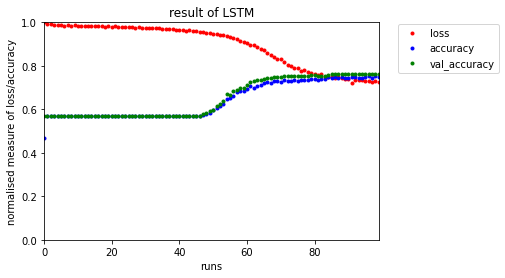

In [ ]:
plt.xlabel("runs")
plt.ylabel("normalised measure of loss/accuracy")
x_len=list(range(len(acc)))
plt.axis([0, max(x_len), 0, 1])
plt.title('result of LSTM')
loss=np.asarray(loss)/max(loss)
plt.plot(x_len, loss, 'r.',label="loss")
plt.plot(x_len, acc, 'b.', label="accuracy")
plt.plot(x_len, val_acc, 'g.', label="val_accuracy")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.2)
plt.show